In [288]:
from math import sqrt
import numpy as np
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr

pd.options.display.float_format='{:,.20}'.format

In [289]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[5:140], data[140:175]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/5))
	test = array(split(test, len(test)/5))
	return train, test


In [290]:
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    
    print("Printing actual and predicted " , actual[0 , :] , predicted[0,:])
    
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = mse
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += np.abs((actual[row,col] - predicted[row,col]))
    score = (s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [291]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.15f' % s for s in scores])
	print('%s: [%.15f] %s' % (name, score, s_scores))
 
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models

In [292]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

In [293]:
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(5):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence

In [294]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 14] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

In [295]:
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)

In [296]:
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence

In [297]:
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 14], predictions)
	return score, scores

In [299]:
# load the new file
df = read_csv('1.csv')

df1 = pd.to_datetime(df['Epoch_Time_of_Clock'])
df['Epoch_Time_of_Clock']=df1
df.index = pd.to_datetime(df['Epoch_Time_of_Clock'],format='%Y-%m-%d %H:%M:%S')

df1 = pd.concat([df['sqrt_A'] , df['e'],df['i0'],df['omega'],df['OMEGA'],df['Del_n'],df['M0']],axis=1)
df1.head()

df3 = pd.DataFrame()

for i in range(1, 6):
    df3["lag_{}".format(i)] = df1.e.shift(i)
    
dataset=df3
# split into train and test
train, test = split_dataset(dataset.values)
# prepare the models to evaluate
models = get_models()
n_input = 5
# evaluate each model
days = ['one', 'two', 'three', 'four', 'five']
for name, model in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(model, train, test, n_input)
    # summarize scores
    print("Score " , score)
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

Defined 10 models


IndexError: index 14 is out of bounds for axis 1 with size 5

df1

In [344]:
df1.loc['2017-11-01 14:00:00']

sqrt_A     5,153.6701965299998847
e        0.0070940352743500013216
i0         0.96871190895600001181
omega      0.63272009923999994463
OMEGA       1.0093728597000000136
Del_n    4.874845914039999901e-09
M0          2.7556365782499998573
Name: 2017-11-01 14:00:00, dtype: float64

In [300]:
dataset.head()

,lag_1,lag_2,lag_3,lag_4,lag_5
Epoch_Time_of_Clock,,,,,
2017-11-01 14:00:00,nan,nan,nan,nan,nan
2017-11-01 16:00:00,0.0070940352743500013216,nan,nan,nan,nan
2017-11-01 18:00:00,0.0070945619372700004235,0.0070940352743500013216,nan,nan,nan
2017-11-01 20:00:00,0.0070945401676000014596,0.0070945619372700004235,0.0070940352743500013216,nan,nan
2017-11-01 22:00:00,0.0070946244522899996193,0.0070945401676000014596,0.0070945619372700004235,0.0070940352743500013216,nan


In [301]:
df = pd.read_csv('1.csv')

In [302]:
df.columns
#df['sqrt_A']=np.power(df['sqrt_A'],2)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'PRN', 'Epoch_Time_of_Clock',
       'SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
       'Del_n', 'M0', 'Cuc', 'e', 'Cus', 'sqrt_A', 'Toe', 'Cic', 'OMEGA',
       'Cis', 'i0', 'Crc', 'omega', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval'],
      dtype='object')

In [303]:
train, test = split_dataset(df.values)

In [337]:
train.shape
test[0]

array([[140, 3553, 1, '2017-11-24 16:00:00', -1.24364160001e-05,
        -2.38742359215e-12, 0, 104, -79.59375, 4.26874923911e-09,
        -1.6536898338600001, -4.23938035965e-06, 0.007125487085430001,
        8.28877091408e-06, 5153.68014526, 489600, 8.56816768646e-08,
        0.632204123645, -6.70552253723e-08, 0.9693719849079999, 221.9375,
        0.631667455074, -7.8499698399e-09, 1.37148569931e-10, 1, 1976, 0,
        1, 0, 5.58793544769e-09, 104, 482406, 0],
       [141, 3566, 1, '2017-11-24 18:00:00', -1.2454111129e-05,
        -2.38742359215e-12, 0, 155, -75.71875, 4.30232206613e-09,
        -0.603540267098, -3.87988984585e-06, 0.00712598324753,
        8.07270407677e-06, 5153.68021965, 496800, 7.07805156708e-08,
        0.632147583324, 1.02445483208e-07, 0.9693720990160001, 228.84375,
        0.631693550606, -8.002833350130001e-09, 6.96457581682e-11, 1,
        1976, 0, 1, 0, 5.58793544769e-09, 155, 489606, 0],
       [142, 3577, 1, '2017-11-24 19:59:44', -1.24732032418e-05,
 

In [305]:
train[0]

array([[5, 135, 1, '2017-11-02 00:00:00', -7.759314030410001e-06,
        -2.38742359215e-12, 0, 69, 29.0, 4.7416260791900006e-09,
        1.72347762985, 1.42678618431e-06, 0.00709622702561,
        3.90969216824e-06, 5153.67224121, 345600, -1.210719347e-07,
        1.00907040139, 8.56816768646e-08, 0.9687207186489999, 308.28125,
        0.632618838977, -8.38927801853e-09, 2.54653464482e-10, 1, 1973,
        0, 1, 0, 5.58793544769e-09, 69, 338406, 0],
       [6, 218, 1, '2017-11-02 12:00:00', -7.857568562030001e-06,
        -2.38742359215e-12, 0, 73, 40.03125, 4.91949063082e-09,
        1.7415583478799999, 2.08988785744e-06, 0.00709870201536,
        4.51132655144e-06, 5153.67212868, 388800, -1.97440385818e-07,
        1.00870849593, 1.4528632164e-07, 0.968731389174, 297.03125,
        0.632462477904, -8.39749264642e-09, 3.48228790841e-10, 1, 1973,
        0, 0, 0, 5.58793544769e-09, 73, 387756, 0],
       [7, 221, 1, '2017-11-02 14:00:00', -7.87433236837e-06,
        -2.38742359215e-1

In [306]:
models = get_models()

Defined 10 models


In [307]:
models['lr']

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [308]:
hist = [x for x in train]
hist

[array([[5, 135, 1, '2017-11-02 00:00:00', -7.759314030410001e-06,
         -2.38742359215e-12, 0, 69, 29.0, 4.7416260791900006e-09,
         1.72347762985, 1.42678618431e-06, 0.00709622702561,
         3.90969216824e-06, 5153.67224121, 345600, -1.210719347e-07,
         1.00907040139, 8.56816768646e-08, 0.9687207186489999, 308.28125,
         0.632618838977, -8.38927801853e-09, 2.54653464482e-10, 1, 1973,
         0, 1, 0, 5.58793544769e-09, 69, 338406, 0],
        [6, 218, 1, '2017-11-02 12:00:00', -7.857568562030001e-06,
         -2.38742359215e-12, 0, 73, 40.03125, 4.91949063082e-09,
         1.7415583478799999, 2.08988785744e-06, 0.00709870201536,
         4.51132655144e-06, 5153.67212868, 388800, -1.97440385818e-07,
         1.00870849593, 1.4528632164e-07, 0.968731389174, 297.03125,
         0.632462477904, -8.39749264642e-09, 3.48228790841e-10, 1, 1973,
         0, 0, 0, 5.58793544769e-09, 73, 387756, 0],
        [7, 221, 1, '2017-11-02 14:00:00', -7.87433236837e-06,
         -

In [309]:
len(hist)

27

In [310]:
hist[0].shape

(5, 33)

In [311]:
train_x , train_y = to_supervised(hist , 5)

In [339]:
#train_x
#np.power(train_x, 2)


In [334]:
train_y[0]

5153.66959381

In [335]:
pipeline = make_pipeline(models['lr'])

In [336]:
pipeline.fit(train_x,train_y)

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('normalize', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [316]:
input_x = train_x[-1, : ]
input_x

array([5153.68056679, 5153.68127251, 5153.68191147, 5153.68182182,
       5153.68195343], dtype=object)

In [317]:
input_data = [x for x in input_x]
np.power(input_data,2)
input_data

[5153.68056679, 5153.68127251, 5153.68191147, 5153.68182182, 5153.68195343]

In [318]:
yhat_sequence = []
for j in range(5):
    # prepare the input data
    X = array(input_data[-n_input:]).reshape(1, n_input)
    print(X)
    # make a one-step forecast
    yhat = model.predict(X)[0]
    print("**")
    print(yhat)
    # add to the result
    yhat_sequence.append(yhat)
    # add the prediction to the input
    input_data.append(yhat)

[[5153.68056679 5153.68127251 5153.68191147 5153.68182182 5153.68195343]]


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [319]:
test.shape

(7, 5, 33)

In [320]:
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = sklearn_predict(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
predictions = array(predictions)

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionW

In [321]:
#test
predictions

array([[5153.68164822, 5153.68177317, 5153.68161354, 5153.68172107,
        5153.68155912],
       [5153.68070318, 5153.68011822, 5153.68079459, 5153.68027835,
        5153.68064454],
       [5153.67928056, 5153.67901454, 5153.67922136, 5153.67898044,
        5153.67923425],
       [5153.6772644 , 5153.67682071, 5153.67750389, 5153.67695566,
        5153.67747976],
       [5153.67560733, 5153.67680053, 5153.67658464, 5153.67667151,
        5153.67640365],
       [5153.67612098, 5153.67685544, 5153.67587238, 5153.67701038,
        5153.67635401],
       [5153.67337766, 5153.67324566, 5153.6733438 , 5153.67350885,
        5153.67376678]])

In [322]:
score, scores = evaluate_forecasts(test[:, :, 14], predictions)

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]


In [323]:
score

0.0018365968424924567

In [324]:
scores

[0.00141711688450284,
 0.002351956058581501,
 0.0017743962954617537,
 0.002110141709506154,
 0.0015293732644100341]

In [325]:
test[:, :, 14]

array([[5153.68014526, 5153.68021965, 5153.68157387, 5153.68034363,
        5153.67912865],
       [5153.68011665, 5153.67901802, 5153.67896843, 5153.67871475,
        5153.68069649],
       [5153.67853355, 5153.67726898, 5153.67762184, 5153.67633247,
        5153.67708969],
       [5153.67686081, 5153.67934036, 5153.67672157, 5153.67558479,
        5153.67490196],
       [5153.67365456, 5153.67473793, 5153.67487907, 5153.67761421,
        5153.67525291],
       [5153.67251396, 5153.67150497, 5153.67233276, 5153.67309189,
        5153.67578506],
       [5153.6744976, 5153.67111397, 5153.67041588, 5153.67055893,
        5153.67198563]], dtype=object)

Defined 10 models
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]
Score  0.0018365968424924567
lr: [0.001836596842492] 0.001417116884503, 0.002351956058582, 0.001774396295462, 0.002110141709506, 0.001529373264410
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.6773082 5153.6773082 5153.6773082 5153.6773082 5153.6773082]
Score  0.0027679352338444525
lasso: [0.002767935233844] 0.002663257502198, 0.003047852721595, 0.003027018930620, 0.002648725002603, 0.002452822012206
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68149956 5153.68159608 5153.68147372 5153.68150132 5153.68136074]
Score  0.0018658639103055715
ridge: [0.001865863910306] 0.001525144368316, 0.002265395192288, 0.001835943403291, 0.002081581257828, 0.001621255329805
Printing actual

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionW

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68186618 5153.68212961 5153.68215036 5153.6823407  5153.68233579]
Score  0.0019390103209454017
huber: [0.001939010320945] 0.001489656016150, 0.002401427368958, 0.001888314723146, 0.002234868651612, 0.001680784844861
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.68164822 5153.68177317 5153.68161354 5153.68172107 5153.68155912]
Score  0.0018365968424924567
lars: [0.001836596842492] 0.001417116884503, 0.002351956058582, 0.001774396295462, 0.002110141709506, 0.001529373264410
Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5153.6773082 5153.6773082 5153.6773082 5153.6773082 5153.6773082]
Score  0.0027679352338444525
llars: [0.002767935233844] 0.002663257502198, 0.003047852721595, 0.003027018930620, 0.002648725002603, 0.002452822012206
Printing actual and predicted  

/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1022: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/shreyas/anaconda3/lib/python3.6/site-packages/

Printing actual and predicted  [5153.68014526 5153.68021965 5153.68157387 5153.68034363 5153.67912865] [5.15532292e+03 1.04053296e+04 1.68105771e+07 5.37778410e+10
 1.72090614e+14]
Score  118984260099974.11
sgd: [118984260099974.109375000000000] 5.138521945925406, 16527.828245960248751, 53942866.187668725848198, 178211585365.001464843750000, 594743034955106.125000000000000


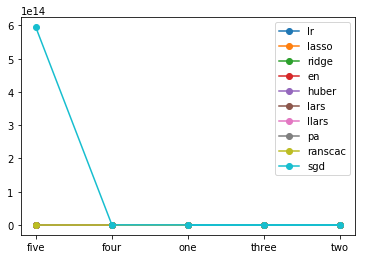

In [326]:
dataset = pd.read_csv('1.csv')
# split into train and test
train, test = split_dataset(dataset.values)
# prepare the models to evaluate
models = get_models()
n_input = 5
# evaluate each model
days = ['one', 'two', 'three', 'four', 'five']
for name, model in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(model, train, test, n_input)
    # summarize scores
    print("Score " , score)
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()